## Setup Project
Import used packages


In [1]:
# import required libraries
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import glob
import warnings
from sklearn import mixture
from sklearn.neighbors import KernelDensity
import itertools
import seaborn as sns
from sklearn.utils.fixes import parse_version

Setup global plot settings

In [2]:

# configure notebook for plotting
%pylab inline --no-import-all 
mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color'] # allows access to colours
# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(20,20)  
matplotlib.rcParams['font.size']=16    
matplotlib.rcParams['savefig.dpi']= 300   
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


## Data entry and preparation
Enter data file location and initiate variables

In [3]:

# import data from Data directory
allPointsFiles = glob.glob('../Data/*/*/points.txt')
allFuzzyFiles = glob.glob('../Data/*/*/fuzzy.txt')
allVaryingPointFiles = glob.glob('../Data/*/*/P*.csv')
allXrayFiles = glob.glob('../Data/XrayFlash.txt')
farPoints = []
midPoints = []
closePoints = []
variablePoints = []
xRayPoints = []
totalPoints = 0


### Import and prepare Points
Iterate through points files and categorize points into close and far points, where close points can be measured by parallax accurately.\
Convert to useful data types in process.\
                      0    1  2     3     4          5                    6                 7
points data format: [Name, x, y, parsec, HRx, Absolute magnitude, Apparent magnitude, Radial Velocity]

In [4]:
for j, pointsFile in enumerate(allPointsFiles):
    try:
        this = Table.read(pointsFile,format='ascii')
        totalPoints= totalPoints+len(this)
        thispar = this['par']
        thism0, thism1, thism2 = (np.log10(this['flux1']), 
                                  np.log10(this['flux2']), 
                                  np.log10(this['flux3']))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist)
        
        # transform coords onto "sky net" based on file path and store in numpy array          
        if pointsFile.rfind('Up')!=-1:
            points = np.array([this['name'], this['y'], -this['x']+90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Front')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Right')!=-1:
            points = np.array([this['name'], this['x'], this['y'], thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Back')!=-1:
            points = np.array([this['name'], this['x']+90, this['y'], thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Left')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+180, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Down')!=-1:
            points = np.array([this['name'], this['y'], -this['x']-90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
            
        # sort into close and far
        for point in points:
            if float(point[3]) > 0.006:
                closePoints.append(point)
            elif float(point[3]) < 0.004:# value chosen to minimize clusters being assigned to mid distance
                farPoints.append(point)   
            else:
                midPoints.append(point)  
    except:
        pass
closePointsNumpy=np.array(closePoints)
midPointsNumpy=np.array(midPoints)
farPointsNumpy=np.array(farPoints)


allPointsNumpy=np.concatenate((closePointsNumpy, midPointsNumpy, farPointsNumpy))

### Import and prepare variable points

In [5]:

for j, varsFile in enumerate(allVaryingPointFiles):
    
    try:
        thisVar = np.array(Table.read(varsFile,format='ascii'))
        name = varsFile[-10:-4]
        basicData=allPointsNumpy[allPointsNumpy[:,0]==name,[1,2,3,4,6]]
        variablePoint=np.array([name,thisVar,basicData[0],basicData[1],basicData[2],basicData[3],basicData[4]])
        variablePoints.append(variablePoint)
    except Exception as e:
        print('Failed: '+ str(e))
        print(varsFile[-10:-4])
        pass
variablePointsNumpy=np.array(variablePoints)

### Categorise and process Fuzzies
A similar process as used on the points data

### Import and prepare Xray flashes


In [6]:
for j, XrayFiles in enumerate(allXrayFiles):
    try:
        this = Table.read(XrayFiles,format='ascii')
        for line in this:
            # transform coords onto "sky net" based on file path and store in numpy array          
            if line['Camera']==('Up'):
                Xrays = np.array([line['y'], -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Front'):
                Xrays = np.array([ line['y']-90, -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Right'):
                Xrays = np.array([ line['x'], line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Back'):
                Xrays = np.array([line['x']+90, line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Left'):
                Xrays = np.array([ line['y']-90, -line['x']+180, line['mag']]).T.tolist()
            elif line['Camera']==('Down'):
                Xrays = np.array([ line['y'], -line['x']-90, line['mag']]).T.tolist()

            xRayPoints.append(Xrays)
    except Exception as e:
        logger.error('Failed: '+ str(e))
        pass
xRayPointsNumpy=np.array(xRayPoints)

## Check Data Entry
A star map to check all are present, a benchmark HR diagram and a cluster map.

### HR Data plot

In [7]:
# figApparentHR = plt.figure()
# ax1 = figApparentHR.add_subplot(2, 1, 1)
# allPoints_HRfloats=(np.concatenate((closePointsNumpy[:,[4,6]],midPointsNumpy[:,[4,6]],farPointsNumpy[:,[4,6]]))).astype(np.float)
# # figure for HR diagram Template
# plt.ylabel('Apparent magnitude')
# plt.xlabel('Log Flux 2 - Log Flux 0')
# plt.title('All Points HR Diagram')
# plt.scatter((allPoints_HRfloats.T)[0].astype(np.float),(allPoints_HRfloats.T)[1].astype(np.float))
# plt.grid()

# ax2 = figApparentHR.add_subplot(2, 1, 2)
# # MeasurablePoints_HRfloats=(np.concatenate((closePointsNumpy[:,[4,5]],midPointsNumpy[:,[4,5]]))).astype(np.float)
# # figure for HR diagram Template
# plt.ylabel('Absolute magnitude')
# plt.xlabel('Log Flux 2 - Log Flux 0')
# plt.title('Measurable Points HR Diagram')
# # plt.scatter((MeasurablePoints_HRfloats.T)[0].astype(np.float),(MeasurablePoints_HRfloats.T)[1].astype(np.float))
# plt.scatter((closePointsNumpy[:,4]).astype(np.float),(closePointsNumpy[:,5]).astype(np.float))
# # plt.scatter((midPointsNumpy[:,4]).astype(np.float),(midPointsNumpy[:,5]).astype(np.float))
# plt.grid()


### Unfolded sky map plot

IndexError: index 1 is out of bounds for axis 0 with size 0

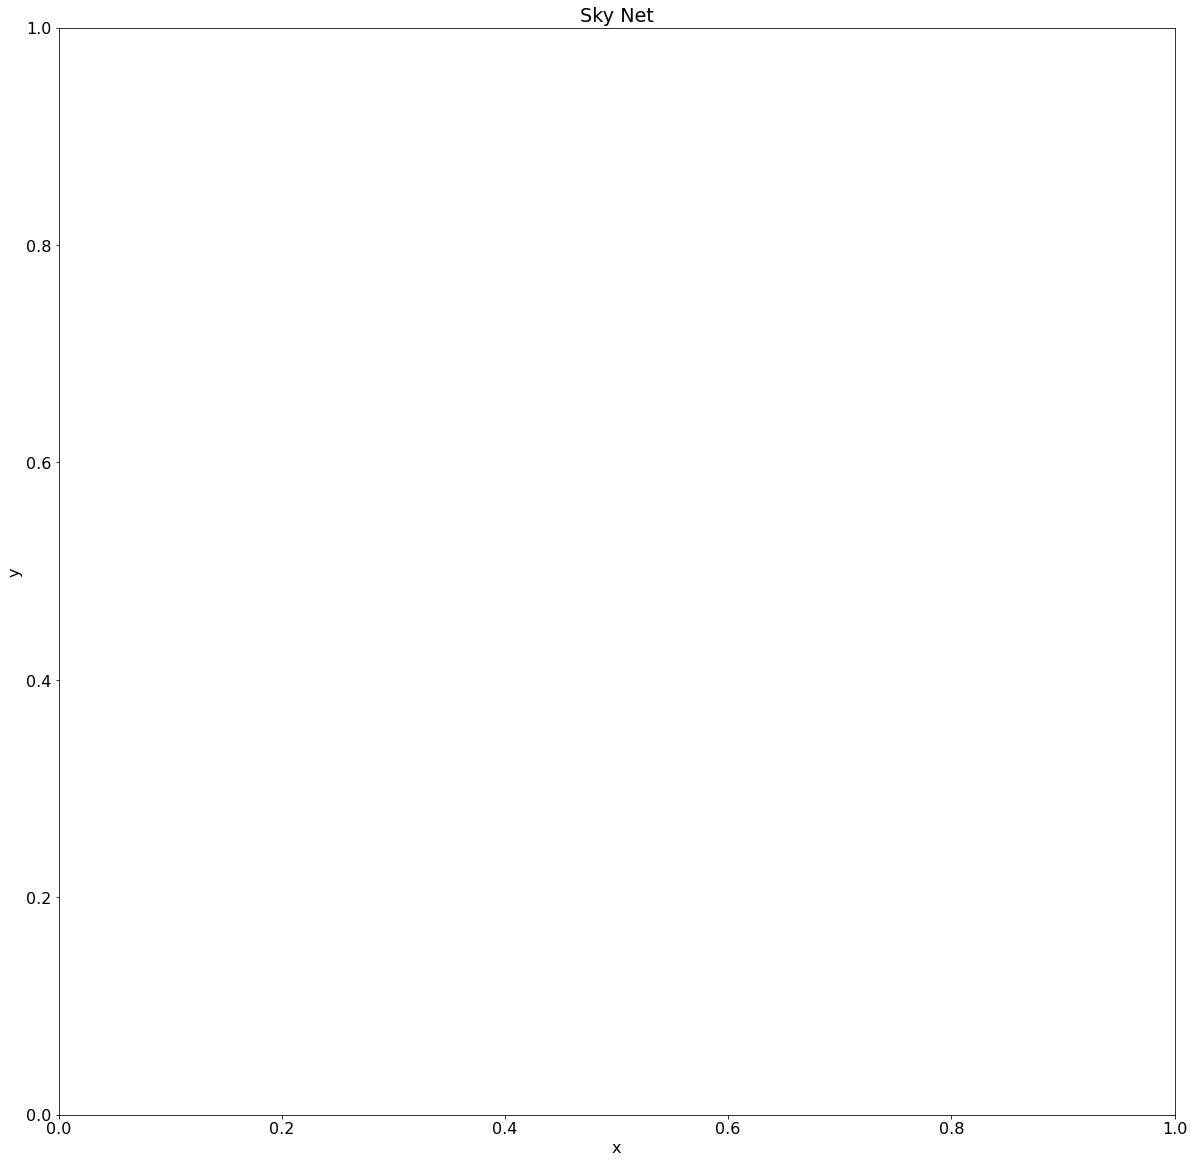

In [8]:
# figure for HR diagram benchmark
skyNet= plt.figure()
ax = skyNet.add_subplot(1, 1, 1)
plt.ylabel('y')
plt.xlabel('x')
plt.title('Sky Net')

plt.scatter((farPointsNumpy.T)[1].astype(np.float),(farPointsNumpy.T)[2].astype(np.float), marker = '.')
plt.scatter((xRayPointsNumpy.T)[0].astype(np.float),(xRayPointsNumpy.T)[1].astype(np.float), marker = 'x')
plt.scatter((variablePointsNumpy.T)[2].astype(np.float),(variablePointsNumpy.T)[3].astype(np.float), marker = '*')
plt.scatter((midPointsNumpy.T)[1].astype(np.float),(midPointsNumpy.T)[2].astype(np.float), marker = '+')
plt.scatter((midPointsNumpy.T)[1].astype(np.float),(midPointsNumpy.T)[2].astype(np.float), marker = '+')


yticksMajor = [-135,-45,45,135,225]
yticksMinor = [-90,0,90,180]
xticksMajor = [-135,-45,45]
xticksMinor = [-90,0]

ax.set_xticks(xticksMajor)
ax.set_yticks(yticksMajor)
ax.set_xticks(xticksMinor, minor=True)
ax.set_yticks(yticksMinor, minor=True)
plt.grid()

## Pre processing
- transform HR diagram data so that y axis runs along main sequence length.

In [ ]:
# Identify benchmark main seqence cluster with BGMM
clusterCount = 4   # clusterCount
countStep = 5
CountTrials = 3
clustersModel = (mixture.BayesianGaussianMixture(
                n_components=clusterCount,
                covariance_type="full",
                n_init = CountTrials
                )).fit(closePointsNumpy[:,[4,5]].astype(np.float))    
clusterShapes = clustersModel.predict(closePointsNumpy[:,[4,5]].astype(np.float))

In [ ]:
## initiate global variables for nested construction

clusters=[]
gradient=[]

matplotlib.rcParams['figure.figsize']=(12,4)  
colorCycle = itertools.cycle(sns.color_palette())
clusterPlots=[]
clusterPlot=mpl.pyplot.figure()
ax1 = clusterPlot.add_subplot(1, 2, 1)

## plot identified HR clusters
for i, (mean, cov, color, weights) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle, clustersModel.weights_)):
    if not np.any(clusterShapes == i) or weights<(0.01/clusterCount):
        continue        
    clusters.append(closePointsNumpy[:,[4,5]][clusterShapes == i, :].astype(np.float))
    
### Benchmark HR diagram cluster plot with cluster identification ellipses
    # plt.grid()
    # plt.scatter(closePointsNumpy[:,4].astype(np.float)[clusterShapes == i], closePointsNumpy[:,5].astype(np.float)[clusterShapes == i], color= color, marker ='x')
    # angle = np.arctan2(w[0][1], w[0][0])
    # angle = 180.0 * angle / np.pi
    # v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    # ell1 = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    # ell1.set_clip_box(ax1.bbox)
    # ell1.set_alpha(weights)
    # ax1.add_artist(ell1)

## get Main sequence to fit polynomial
clusterSize=0
i=0
MSindex=0
for c in clusters:
    if len(c)>clusterSize:
        clusterSize=len(c)
        MSindex=i
    i=i+1
mainSequenceBenchmark=clusters[MSindex]
MSFit=np.poly1d(np.polyfit(mainSequenceBenchmark[:,0],mainSequenceBenchmark[:,1],2))
# Transform all close points HR values
x=closePointsNumpy[:,4].astype(np.float)
transformedMags=closePointsNumpy[:,5].astype(np.float)-np.square(x)*MSFit.c[0]-x*MSFit.c[1]-MSFit.c[2]


### plot transformed HR diagram
# ax2 = clusterPlot.add_subplot(1, 2, 2)
# plt.grid()
# plt.scatter(x,transformedMags, color= color, marker ='x')

## Transform all points data
closePointsNumpy = np.c_[closePointsNumpy, closePointsNumpy[:,5].astype(np.float)-np.square(closePointsNumpy[:,4].astype(np.float))*MSFit.c[0]-closePointsNumpy[:,4].astype(np.float)*MSFit.c[1]-MSFit.c[2]]
midPointsNumpy = np.c_[midPointsNumpy, midPointsNumpy[:,6].astype(np.float)-np.square(midPointsNumpy[:,4].astype(np.float))*MSFit.c[0]-midPointsNumpy[:,4].astype(np.float)*MSFit.c[1]-MSFit.c[2]]
farPointsNumpy = np.c_[farPointsNumpy, farPointsNumpy[:,6].astype(np.float)-np.square(farPointsNumpy[:,4].astype(np.float))*MSFit.c[0]-farPointsNumpy[:,4].astype(np.float)*MSFit.c[1]-MSFit.c[2]]

### cubic transformation
# closePointsNumpy = np.c_[closePointsNumpy, closePointsNumpy[:,5].astype(np.float)-np.square(closePointsNumpy[:,4].astype(np.float))*MSFit.c[0]-closePointsNumpy[:,4].astype(np.float)*MSFit.c[1]-MSFit.c[2]]
# midPointsNumpy = np.c_[midPointsNumpy, midPointsNumpy[:,6].astype(np.float)-np.power(midPointsNumpy[:,4].astype(np.float),3)*MSFit.c[0]-np.square(midPointsNumpy[:,4].astype(np.float))*MSFit.c[1]-midPointsNumpy[:,4].astype(np.float)*MSFit.c[2]-MSFit.c[3]]
# farPointsNumpy = np.c_[farPointsNumpy, farPointsNumpy[:,6].astype(np.float)-np.power(farPointsNumpy[:,4].astype(np.float),3)*MSFit.c[0]-np.square(farPointsNumpy[:,4].astype(np.float))*MSFit.c[1]-farPointsNumpy[:,4].astype(np.float)*MSFit.c[2]-MSFit.c[3]]
    

### investigate transformed apparent magnitude distribution

In [ ]:

# bandwidth=np.std(mainSequenceBenchmark[:,1].reshape(-1,1))/10
# X_plot = np.linspace(min(transformedMags)-0.1*np.abs(min(transformedMags)), max(transformedMags)+0.1*np.abs(max(transformedMags)), 1000)
# log_dens = MSKD.score_samples(X_plot.reshape(-1, 1))
# HRmagDensity=mpl.pyplot.figure()
# ax1 = HRmagDensity.add_subplot(1, 1, 1)
# kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(transformedMags.reshape(-1, 1))
# log_dens = kde.score_samples(X_plot.reshape(-1, 1))
# ax1.fill(X_plot, np.exp(log_dens), fc="#AAAAFF")

## Cluster Identification

Process:
- Use x, y in a Bayesian Gaussian mixture model (BGMM) to get proto-clusters
- Rerun BGMM on each proto-cluster to get subclusters
- combine subclusters that are indistinguishable in mean and main sequence position
    - distinguishability criteria TBD

### Identify Proto-clusters

In [ ]:
# BGMM parameters
clusterCount = 1   #initial clusterCount
countStep = 1      #cluster count step size
CountTrials = 1    #trials per fit
WCP = 1            #weight_concentration_prior
MPR = 1            #mean_precision_prior
# Data for BGMM pror
clusterPrior=closePointsNumpy[:,[1,2,4,5]].astype(np.float)
# Data for BGMM
farPoints_floats=np.concatenate([farPointsNumpy[:,[1,2,4,6,7,8]], midPointsNumpy[:,[1,2,4,6,7,8]]]).astype(np.float)
# loop with BGMM cluster algorithm and check when some weights go to 0.
clustersModel = (mixture.BayesianGaussianMixture(
                tol=0.01,
                n_components=clusterCount,
                weight_concentration_prior=WCP,
                mean_precision_prior=MPR,
                covariance_type="full",
                n_init = CountTrials
                )).fit(farPoints_floats[:,[0,1,4]])
while min(clustersModel.weights_)>(0.01/clusterCount):
    
    clusterCount=clusterCount+countStep
    
    clustersModel = (mixture.BayesianGaussianMixture(
                    tol=0.01,
                    n_components=clusterCount,
                    weight_concentration_prior=WCP, 
                    mean_precision_prior=MPR, covariance_type="full",
                    n_init = CountTrials
                    )).fit(farPoints_floats[:,[0,1,4]])

clusterShapes = clustersModel.predict(farPoints_floats[:,[0,1,4]])


### Collate Individual Proto-clusters

In [ ]:
minClusterSize=10
protoClusters=[]
for i, weights in enumerate(clustersModel.weights_):
    
    if not np.any(clusterShapes == i) or weights<(0.01/clusterCount) or len(farPoints_floats[clusterShapes == i, :])<minClusterSize:
        continue
    protoClusters.append(farPoints_floats[clusterShapes == i, :])


### Plot individual proto-clusters

In [ ]:
matplotlib.rcParams['figure.figsize']=(18,4)  
colorCycle = itertools.cycle(sns.color_palette())
protoclusterPlots=[]
for i, (mean, cov, color, weights) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle, clustersModel.weights_)):
    
    if not np.any(clusterShapes == i) or weights<(0.01/clusterCount):
        continue
    v, w = sp.linalg.eigh(cov)
    protoclusterPlots.append(mpl.pyplot.figure())
    ### Sky map cluster plot
    ax1 = protoclusterPlots[-1].add_subplot(1, 2, 1)
    plt.grid()
    plt.scatter(farPoints_floats[clusterShapes == i, 0], farPoints_floats[clusterShapes == i, 1], c= farPoints_floats[clusterShapes == i,4], cmap= 'bwr', marker ='x')

    
    ### HR diagram cluster plot
    ax2 = protoclusterPlots[-1].add_subplot(1, 2, 2)
    plt.grid()
    mpl.pyplot.scatter(farPoints_floats[clusterShapes == i, 2], farPoints_floats[clusterShapes == i, 5], marker = 'x', color=color)
    
    yticksMajor = [-12,-10,-8, -6,-4, -2, 0]
    xticksMajor = [-1,-0.5,0,0.5,1]

    ax2.set_xticks(xticksMajor)
    ax2.set_yticks(yticksMajor)

plt.show()   

In [ ]:
# # Plot the Proto-clusters on skymap and HR diagram
# ClusterFitSkyPlot= mpl.pyplot.figure()
# ax = ClusterFitSkyPlot.add_subplot(1, 1, 1)
# HRFitPlot= mpl.pyplot.figure()
# HRax = HRFitPlot.add_subplot(1, 1, 1)
# colorCycle = itertools.cycle(sns.color_palette())
# for i, (mean, cov, color, weights) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle, clustersModel.weights_)):
#     v, w = sp.linalg.eigh(cov)
#     if not np.any(clusterShapes == i) or weights<(0.01/clusterCount):
#         continue
#     mpl.pyplot.figure(ClusterFitSkyPlot)
#     mpl.pyplot.sca(ax)
#     plt.scatter(farPoints_floats[clusterShapes == i, 0], farPoints_floats[clusterShapes == i, 1], color= color, marker ='x')
#     angle = np.arctan2(w[0][1], w[0][0])
#     angle = 180.0 * angle / np.pi
#     v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
#     ell.set_clip_box(ax.bbox)
#     ell.set_alpha(weights)
#     ax.add_artist(ell)
    
#     mpl.pyplot.figure(HRFitPlot)
#     mpl.pyplot.sca(HRax)
#     mpl.pyplot.scatter(farPoints_floats[clusterShapes == i, 2], farPoints_floats[clusterShapes == i, 3], marker = 'x', color=color)
    
# plt.grid()
# mpl.pyplot.figure(ClusterFitSkyPlot)
# mpl.pyplot.sca(ax)
# plt.grid()
# plt.show()   

### Seperate Proto-clusters into subclusters, isolate main sequence then collate and plot

In [ ]:
### subCluster list element structure: [points list [x,y,HRx,HRy,RV, transformed-HRy], main-sequence points array, main-sequence gaussian, area, mean, extent]
subClusterPlots=[]
subClusters=[]      # list of subclusters, each element: [0] is all points in subcluster, [1] is main sequence points
totalPointsPC=0
for cluster in protoClusters:
    totalPointsPC=totalPointsPC+len(cluster[:,0])
# model subclusters
    # Subcluster parameters
    minSubclusterSize=10 # 
    # BGMM parameters
    clusterCount = 4   #initial clusterCount
    countStep = 5
    CountTrials = 4
    WCP = 1            #weight_concentration_prior
    MPR = 1            #mean_precision_prior
    features=[0,1,4]
## try splitting curent protoCluster into subClusters
    clustersModel = (mixture.BayesianGaussianMixture(
                    tol=0.01,
                    n_components=clusterCount,
                    weight_concentration_prior=WCP,
                    mean_precision_prior=MPR,
                    covariance_type="full",
                    n_init = CountTrials
                    )).fit(cluster[:,features])
    subClusterShapes = clustersModel.predict(cluster[:,features])
# collate subclusters
    for i, (weights) in enumerate(clustersModel.weights_):
        if not np.any(subClusterShapes == i) or weights<(0.01/clusterCount) or len(cluster[subClusterShapes == i, :])<minSubclusterSize:
            continue
        # subClusters[-1].append([])
        subClusters.append([])
        subClusters[-1].append(cluster[subClusterShapes == i, :])

        
        
# Isolate main sequence in each subCluster 

for subCluster in subClusters:
    clusterCount=3    
    subClustersModel = (mixture.BayesianGaussianMixture(
                    n_components=clusterCount,
                    covariance_type="full",
                    n_init = CountTrials
                    )).fit(subCluster[0][:,features])
    subClusterSequenceShapes = subClustersModel.predict(subCluster[0][:,features])

    ## identified HR clusters
    subClusterSequences=[]
    for i, weights in enumerate(subClustersModel.weights_):
        if not np.any(subClusterSequenceShapes == i) or weights<(0.01/clusterCount):
            continue        
        subClusterSequences.append(subCluster[0][subClusterSequenceShapes == i, :])
    
    ## get Main sequence (the one with the most points)
    clusterSize=0
    MSindex=0
    for j,sequence in enumerate(subClusterSequences):
        if len(sequence)>clusterSize:
            clusterSize=len(sequence)
            MSindex=j
        
    subCluster.append(subClusterSequences[MSindex])





    
# Calculate SubCluster Transformed main sequence HR Gaussian Kernal Densities (SCTMSHRGKD), mean, area and extent
SCTMSHRGKD=[]         
X_plot = np.linspace(min(farPoints_floats[:,5]-2),2, 1200)
for i, subCluster in enumerate(subClusters):
    HRy = subCluster[1][:,5].reshape(-1,1)
    bandwidth=np.std(HRy)
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(HRy)
    dens =  np.exp(kde.score_samples(X_plot.reshape(-1, 1)))
    subCluster.append(dens)
    subCluster.append((max(subCluster[0].T[0])-min(subCluster[0].T[0]))*(max(subCluster[0].T[1])-min(subCluster[0].T[1]))) #area
    subCluster.append((np.mean(subCluster[0].T[0]),np.mean(subCluster[0].T[1]))) #mean
    subCluster.append((min(subCluster[0].T[0]), max(subCluster[0].T[0]), min(subCluster[0].T[1]), max(subCluster[0].T[1]))) #extent

    
# Plot subClusters
for i, subCluster in enumerate(subClusters):
    subClusterPlots.append(mpl.pyplot.figure())
    ### Sky map cluster plot
    ax1 = subClusterPlots[-1].add_subplot(1, 3, 1)
    plt.grid()
    mpl.pyplot.scatter(subCluster[0][:,0], subCluster[0][:,1], c= subCluster[0][:,4], cmap= 'bwr', marker ='x')
    ### HR diagram cluster plot
    ax2 = subClusterPlots[-1].add_subplot(1, 3, 2)
    plt.grid()
    mpl.pyplot.scatter(subCluster[0][:,2],subCluster[0][:,5], marker = 'x', color='blue')
    mpl.pyplot.scatter(subCluster[1][:,2],subCluster[1][:,5], marker = '+', color='green')
    ax3 = subClusterPlots[-1].add_subplot(1, 3, 3)
    ax3.fill(X_plot, subCluster[2], fc="#AAAAFF")
    ax3.set_xlim(min(farPoints_floats[:,4]),2)
    # ax3.set_ylim(0,2)
    plt.grid()
plt.show() 

## Combine subclusters into clusters

criteria for combining:
- smaller subcluster mean is within larger subcluster extent
- mean of main sequence transformed apparent magnitude of each subcluster is indestinguishable according to t-distribution

In [ ]:
totalPointsSC1=0
subClusters=np.array(subClusters)
sortedSubClusters=(np.flip(subClusters[subClusters[:, 3].argsort()],axis=0)).tolist()
for i, subCluster in enumerate(sortedSubClusters):
    subCluster.append(i) #extent
sortedSubClusters=np.array(sortedSubClusters)
available=np.array([1] * len(sortedSubClusters))
for hostCluster in sortedSubClusters:
    if hostCluster[-1]==1:
        # print("Host: ", hostCluster[-1])
        for i, otherCluster in enumerate(sortedSubClusters[available == 1,:]):
            # print('    other: ', otherCluster[-1], ' index: ', i)
            if (otherCluster[-1]!=hostCluster[-1]
                and otherCluster[4][0]>hostCluster[5][0]
                and otherCluster[4][0]<hostCluster[5][1]
                and otherCluster[4][1]>hostCluster[5][2]
                and otherCluster[4][1]<hostCluster[5][3]):
                    tTest=sp.stats.ttest_ind(hostCluster[1][:,5], otherCluster[1][:,5], axis=0, equal_var=False)
                    # print('        ',tTest)
                    if tTest[1]>0.05:
                        # print('        match with ', otherCluster[-1], ' at index ', i)
                        hostCluster[0]= np.append(hostCluster[0],otherCluster[0],axis=0)
                        hostCluster[1]= np.append(hostCluster[1],otherCluster[1],axis=0)
                        hostCluster[4]=(np.mean(hostCluster[0].T[0]),np.mean(hostCluster[0].T[1]))
                        hostCluster[5]=(min(hostCluster[0].T[0]), max(hostCluster[0].T[0]), min(hostCluster[0].T[1]), max(hostCluster[0].T[1]))
                        available[otherCluster[-1]] = 0
clusters=sortedSubClusters[available == 1,:]

        

In [ ]:
totalPointsSC2=0
sortedClusters=clusters
available=np.array([1] * len(sortedSubClusters))
for hostCluster in sortedSubClusters:
    if hostCluster[-1]==1:
        totalPointsSC2=totalPointsSC2+len(hostCluster[0][:,1])
        # print("Host: ", hostCluster[-1])
        for i, otherCluster in enumerate(sortedSubClusters[available == 1,:]):
            # print('    other: ', otherCluster[-1], ' index: ', i)
            if (otherCluster[-1]!=hostCluster[-1]
                and otherCluster[4][0]>hostCluster[5][0]
                and otherCluster[4][0]<hostCluster[5][1]
                and otherCluster[4][1]>hostCluster[5][2]
                and otherCluster[4][1]<hostCluster[5][3]):
                    tTest=sp.stats.ttest_ind(hostCluster[1][:,5], otherCluster[1][:,5], axis=0, equal_var=False)
                    # print('        ',tTest)
                    if tTest[1]>0.1:
                        # print('        match with ', otherCluster[-1], ' at index ', i)
                        hostCluster[0]= np.append(hostCluster[0],otherCluster[0],axis=0)
                        hostCluster[1]= np.append(hostCluster[1],otherCluster[1],axis=0)
                        hostCluster[4]=(np.mean(hostCluster[0].T[0]),np.mean(hostCluster[0].T[1]))
                        hostCluster[5]=(min(hostCluster[0].T[0]), max(hostCluster[0].T[0]), min(hostCluster[0].T[1]), max(hostCluster[0].T[1]))
                        available[otherCluster[-1]] = 0
clusters=sortedSubClusters[available == 1,:]

# create cluster stats: [mean(x,y,z),std(x,y,z),mean(radial velocity),std(radial velocity)
totalPoints=0
clusterStats=[]
for cluster in clusters:
    thisClusterPoints=len(cluster[0][:,0])
    totalPoints=totalPoints+len(cluster[0][:,0])
    clusterStats.append([(np.mean(cluster[0][:,0]), np.std(cluster[0][:,0])), (np.mean(cluster[0][:,1]), np.std(cluster[0][:,1])), (np.mean(np.float_power(10,(-cluster[1][:,5])/2)), np.std(np.float_power(10,(-cluster[1][:,5])/2)))])

### Plot final clusters

In [ ]:
matplotlib.rcParams['figure.figsize']=(12,4)  
colorCycle = itertools.cycle(sns.color_palette())
clusterPlots=[]
for i, (cluster, color) in enumerate(zip(clusters, colorCycle)):
  
    clusterPlots.append(mpl.pyplot.figure())
    ### Sky map cluster plot
    ax1 = clusterPlots[-1].add_subplot(1, 2, 1)
    title='Plot ' + str(i) + ', Cluster ' + str(cluster[-1])
    plt.title(title)
    plt.grid()
    plt.scatter(cluster[0][:,0], cluster[0][:,1], c= cluster[0][:,4], cmap= 'bwr', marker ='x')
  
    ### HR diagram cluster plot
    ax2 = clusterPlots[-1].add_subplot(1, 2, 2)
    plt.grid()
    mpl.pyplot.scatter(cluster[0][:,2], cluster[0][:,5], marker = 'x', c='blue')
    mpl.pyplot.scatter(cluster[1][:,2], cluster[1][:,5], marker = '*', color='green')
    
    yticksMajor = [-8, -6,-4, -2, 0]
    xticksMajor = [-1,-0.5,0,0.5,1]

    ax2.set_xticks(xticksMajor)
    ax2.set_yticks(yticksMajor)

# plt.show()   

In [ ]:
farPointsNumpy
totalPointsPC
totalPointsSC1
totalPointsSC2
totalPoints